Transfer Learning **Resnet 50**

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob


In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [4]:
IMAGE_SIZE = [224, 224]


In [5]:
train_path = '/content/drive/MyDrive/plant/train'
valid_path = '/content/drive/MyDrive/plant/val'


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [8]:
for layer in resnet.layers:
    layer.trainable = False


In [9]:
folders = glob('/content/drive/MyDrive/plant/train/*')  # Adjust the path accordingly

# Custom layers on top of ResNet
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)


In [10]:
model = Model(inputs=resnet.input, outputs=prediction)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:

# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   preprocessing_function=preprocess_input )

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_input)

In [14]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/plant/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1981 images belonging to 4 classes.


In [15]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/plant/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18 images belonging to 4 classes.


In [16]:
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)


Epoch 1/20
62/62 [==============================] - 49s 688ms/step - loss: 2.5504 - accuracy: 0.3927 - val_loss: 1.2071 - val_accuracy: 0.5556
Epoch 2/20
62/62 [==============================] - 38s 614ms/step - loss: 1.1585 - accuracy: 0.5396 - val_loss: 1.6638 - val_accuracy: 0.5556
Epoch 3/20
62/62 [==============================] - 36s 587ms/step - loss: 1.0162 - accuracy: 0.6042 - val_loss: 0.7754 - val_accuracy: 0.6667
Epoch 4/20
62/62 [==============================] - 38s 611ms/step - loss: 0.9996 - accuracy: 0.6169 - val_loss: 0.9210 - val_accuracy: 0.6667
Epoch 5/20
62/62 [==============================] - 37s 599ms/step - loss: 0.8721 - accuracy: 0.6562 - val_loss: 0.9431 - val_accuracy: 0.6111
Epoch 6/20
62/62 [==============================] - 37s 599ms/step - loss: 0.7488 - accuracy: 0.6976 - val_loss: 0.7642 - val_accuracy: 0.7222
Epoch 7/20
62/62 [==============================] - 36s 582ms/step - loss: 0.8222 - accuracy: 0.6694 - val_loss: 0.6054 - val_accuracy: 0.7222

In [17]:
import matplotlib.pyplot as plt

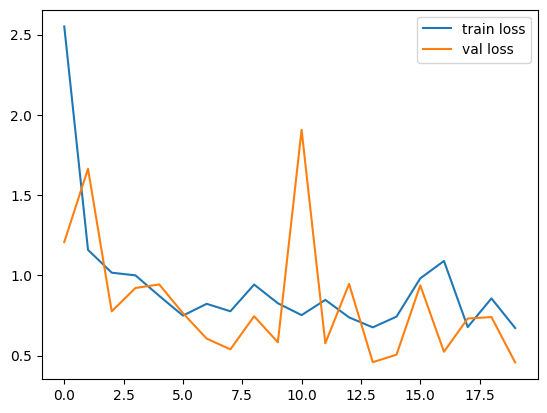

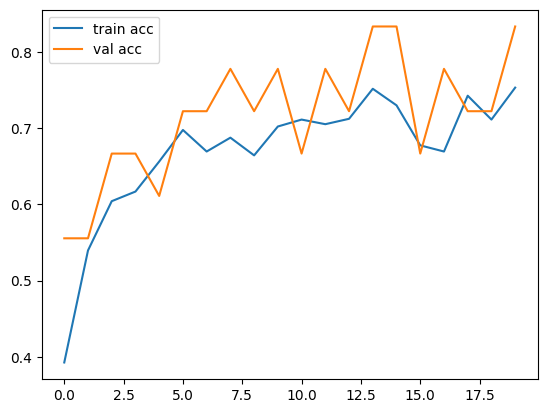

<Figure size 640x480 with 0 Axes>

In [18]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [19]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set, steps=len(test_set))

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 [==============================] - 2s 2s/step - loss: 0.4568 - accuracy: 0.8333
Test Loss: 0.4568
Test Accuracy: 0.8333
